In [1]:
import monai 
from monai.transforms import (
    Compose,
    LoadImaged,
    RandCropByPosNegLabeld,
    EnsureChannelFirstd,
    ScaleIntensityd,
    Spacingd)
import nibabel
import tqdm
import numpy as np
from torchmetrics import MeanSquaredError
import time
from monai.networks.nets import UNet
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, Dataset ,nifti_saver, PatchDataset, DataLoader, PersistentDataset
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob
from monai.networks.blocks import Convolution
from monai.utils import progress_bar
import torch.nn as nn
import torchmetrics 
from pytorchtools import EarlyStopping

/local/fogunsan.9591362.0/tmp/kslurm-venv-caavagqt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
date = "July14" # day we're getting models from
test_gad_t1= sorted(glob('/project/6050199/akhanf/cfmm-bids/data/Lau/degad/derivatives/passing_dataset/sub-P*/*rescaled_T1w.nii.gz'))[-1:]
# gad images who's corresponding nongad images underwent a rigid transform
test_nongad_t1= sorted(glob('/project/6050199/akhanf/cfmm-bids/data/Lau/degad/derivatives/passing_dataset/sub-P*/*nongad_normalized_fcm.nii.gz'))[-1:] # nongad images which underwent a rigid transform and underwent fcm normalization
test_files = [{"image": gad_name, "label": nongad_name} for gad_name, nongad_name in zip(test_gad_t1,test_nongad_t1)] #creates list of dictionaries, with gad and nongad images labelled



In [5]:
CNN = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 128, 256, 512, 1024, 1024, 1024),
    strides=(2, 2, 2, 2, 1, 1, 1),
    dropout=0.2,
    norm='BATCH'
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
CNN.apply(monai.networks.normal_init)
CNN_model = CNN.to(device)

In [6]:
CNN_model.load_state_dict(torch.load(f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/checkpoint.pt'))
CNN_model.eval()

UNet(
  (model): Sequential(
    (0): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (D): Dropout(p=0.2, inplace=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Convolution(
          (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.2, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (1): SkipConnection(
          (submodule): Sequential(
            (0): Convolution(
              (conv): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (adn): ADN(
                (N): BatchNorm3d(1

In [7]:
inference_transforms = Compose( #loading full image
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ])
        

infer_ds = Dataset(data=test_files, transform=inference_transforms) 
infer_loader = DataLoader(infer_ds, batch_size=1, shuffle=True) #using pytorch's dataloader




In [8]:
degad_imgs = []
gad_infer_imgs = []
nongad_infer_imgs = []
sub_list = []
for i,infer_imgs in enumerate(infer_loader):
    gad_infer_imgs.append(infer_imgs["image"])
    nongad_infer_imgs.append(infer_imgs["label"])
    with torch.no_grad():# to avoid memory accumulation error
        output_degad_img = sliding_window_inference(inputs = infer_imgs["image"].to('cpu'), roi_size = (32,32,32), sw_batch_size= 5, predictor = CNN_model.to('cuda'), overlap = 0.15, mode = "gaussian", sigma_scale = 0.25, sw_device= 'cuda', device = 'cpu', progress = True )
    degad_img =output_degad_img[0][0] # reshaping to exclude batch and channels 
    gad_image= nibabel.load(test_files[i]["image"]) # getting original gad image back to compare to 
    gad_image_file = test_files[i]["image"]
    sub = os.path.basename(gad_image_file).split("_")[0]
    sub_list.append(sub)
    degad_name = f'{sub}_acq-degad_T1w.nii.gz'
    degad_file = nibabel.Nifti1Image(degad_img.detach().numpy()*100, affine= gad_image.affine,header= gad_image.header) # with same header as inference gad 
    output_dir = f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/degad_outputs'
    os.makedirs(f'{output_dir}/bids/{sub}/ses-pre/anat', exist_ok=True)# save in bids format
    output_path = f'{output_dir}/bids/{sub}/ses-pre/anat/{degad_name}'
    nibabel.save(degad_file,output_path) 
    degad_imgs.append(output_degad_img)

100%|██████████| 198/198 [00:30<00:00,  6.49it/s]


In [9]:
### to make a descriptionfile, changes, scans.json, readme, participants.json and participants.t

In [10]:
# List of necessary files to copy to put in bids format
files = ['CHANGES', 'scans.json', 'dataset_description.json','participants.json','README']

# Copy each file to the destination directory
for file in files:
    shutil.copy(f'/project/6050199/akhanf/cfmm-bids/data/Lau/degad/bids/{file}', f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/degad_outputs/bids/')

In [11]:


with open('/project/6050199/akhanf/cfmm-bids/data/Lau/degad/bids/participants.tsv', 'r') as file:
    lines = file.readlines()
    header = lines[0]
    matching_rows = [line for line in lines[1:] if line.split()[0] in sub_list]

with open(f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/degad_outputs/bids/participants.tsv', 'w') as file:
    file.write(header)
    file.writelines(matching_rows)
    
    

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


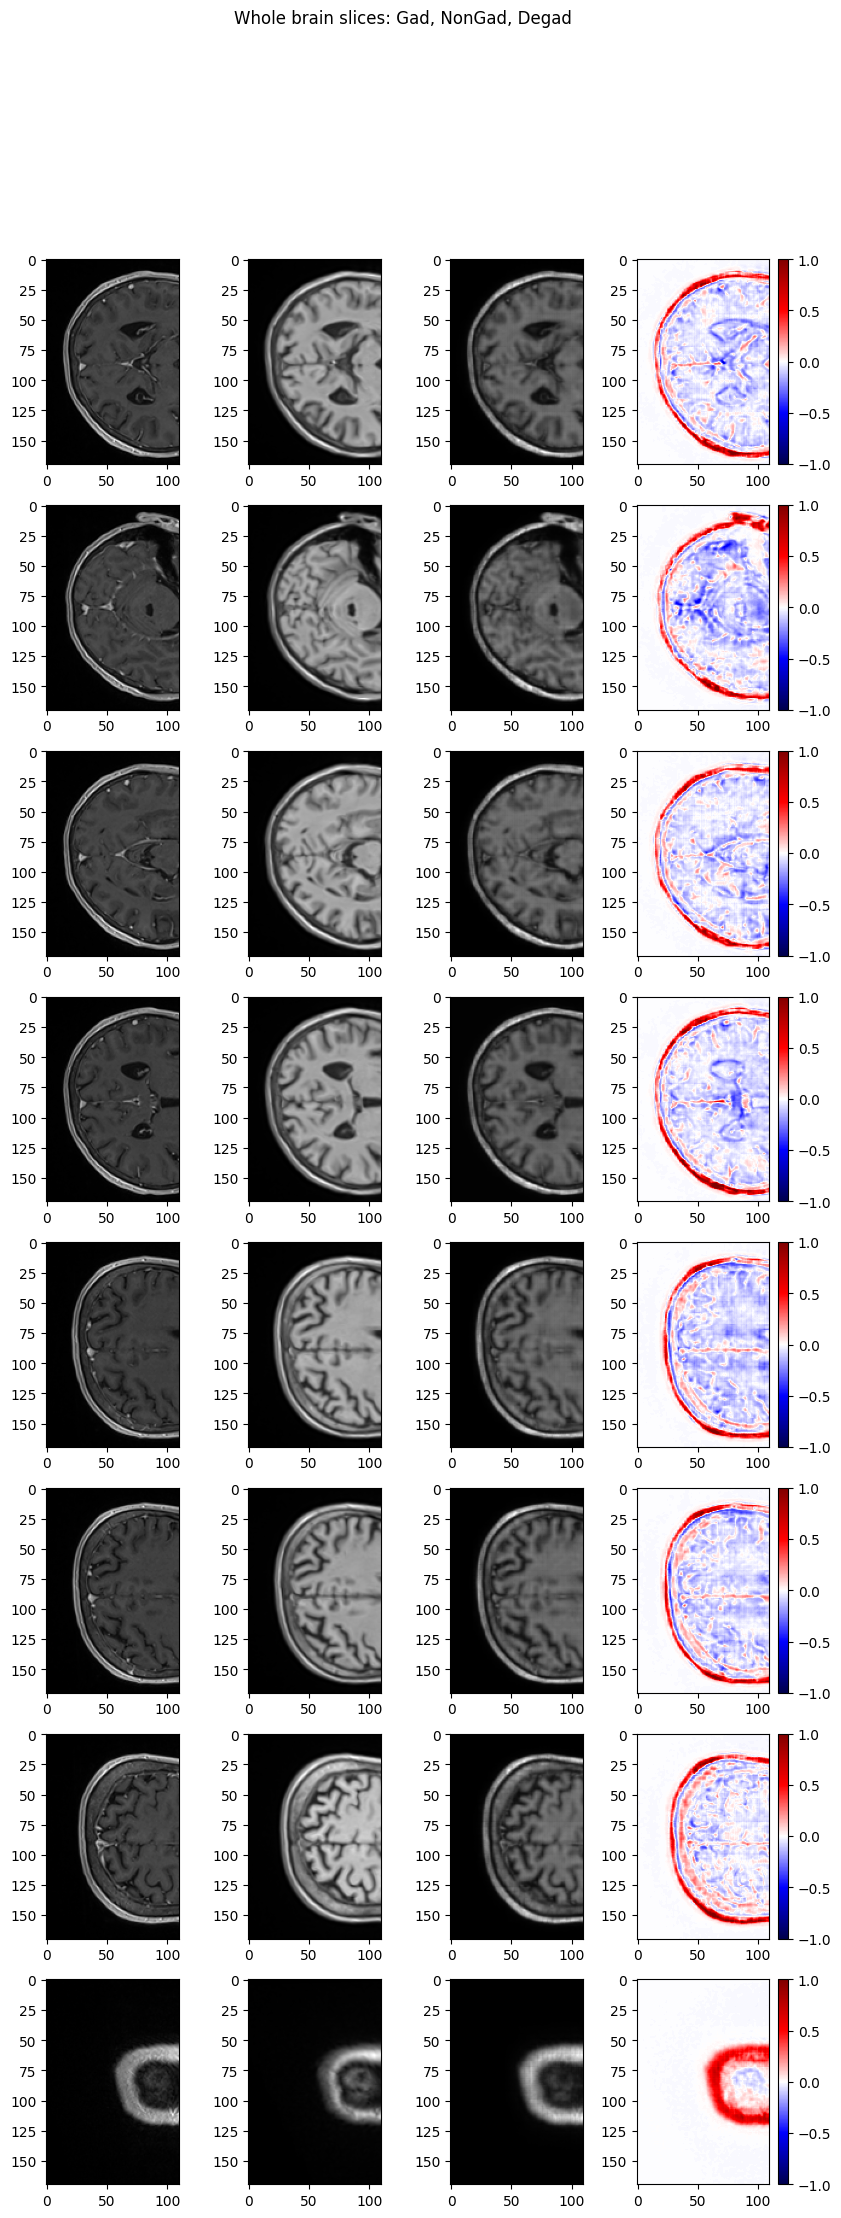

In [14]:
import random
## generating random whole brain slices
fig, axes = plt.subplots(8, 4,figsize=(10,25))
plt.suptitle('Whole brain slices: Gad, NonGad, Degad')

for i in range (1,33,4):
    plt.subplot(8, 4, i)
    x = random.randint(80, 190)
    plt.imshow(gad_infer_imgs[0][0, 0,40:210 ,40:150, x].cpu().data.numpy(), cmap ="gray")
    
    plt.subplot(8, 4, i+1)
    plt.imshow(nongad_infer_imgs[0][0, 0, 40:210 , 40:150, x].cpu().data.numpy(), "gray")
    
    plt.subplot(8, 4, i+2)
    plt.imshow(degad_imgs[0][0, 0, 40:210,40:150, x].cpu().data.numpy(), "gray")
    
    plt.subplot(8, 4, i+3)
    noise_vector = degad_imgs[0][0,0,:,:,:] - nongad_infer_imgs[0][0,0,:,:,:] 
    #pos values are where model overestimated intensities and neg values are where the model underestimated
    plt.imshow(noise_vector[40:210,40:150, x].cpu().data.numpy(), "seismic",vmin=-1,vmax=1)
    plt.colorbar()
plt.savefig(f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/degad_outputs/figure_whole_brain.png')
   

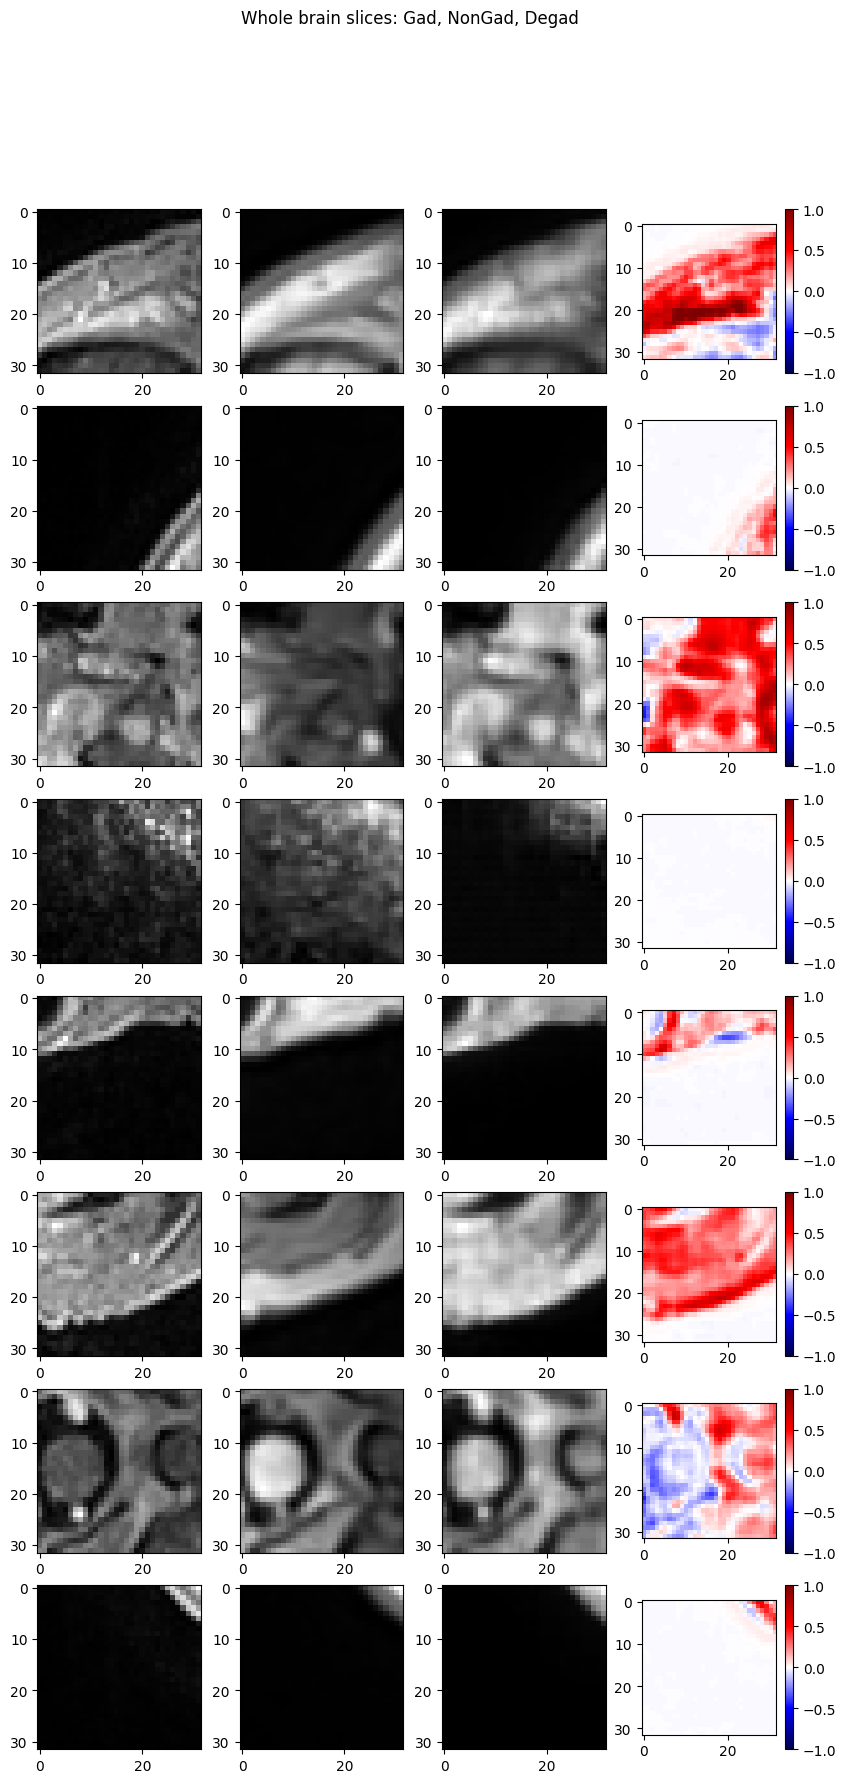

In [15]:
#generating random 32x32 slices
fig, axes = plt.subplots(8, 4,figsize=(10,20))
plt.suptitle('Whole brain slices: Gad, NonGad, Degad')

for i in range (1,33,4):
    
    x = random.randint(40, 190)
    y = random.randint(40, 190)
    plt.subplot(8, 4, i)
    plt.imshow(gad_infer_imgs[0][0, 0, x:x+32,y:y+32 ,50].cpu().data.numpy(), cmap ="gray")
    plt.subplot(8, 4, i+1)
    plt.imshow(nongad_infer_imgs[0][0, 0, x:x+32,y:y+32 ,50].cpu().data.numpy(), "gray")
    plt.subplot(8, 4, i+2)
    plt.imshow(degad_imgs[0][0, 0, x:x+32,y:y+32,50].cpu().data.numpy(), "gray")
    plt.subplot(8, 4, i+3)
    noise_vector = degad_imgs[0][0,0,:,:,:] - nongad_infer_imgs[0][0,0,:,:,:] 
    plt.imshow(noise_vector[x:x+32,y:y+32,50].cpu().data.numpy(), "seismic",vmin=-1,vmax=1)
    plt.colorbar()

plt.savefig(f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/degad_outputs/figure_32_patches.png')    

In [ ]:
#now can run fmriprep on outputs
#bidsBatch -j Long fmriprep_21.0.0 /home/fogunsan/scratch/degad/derivatives/UNET/{date}/degad_outputs/bids/ /home/fogunsan/scratch/degad/derivatives/UNET/{date}/degad_outputs/fmriprep/ participant --anat-only --skip_bids_validation --omp-nthreads 8 --nprocs 16